In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pygimli as pg # Muy importante tener PyGIMLi instalado
from pygimli.physics import VESManager
from pygimli.physics.ves import VESManager  

import scipy.stats as stats
from scipy.stats import norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from typing import Dict, Any, List, Tuple, Optional

import joblib  # Para guardar y cargar modelos

import seaborn as sns


from scipy import stats
from scipy.stats import norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma

In [11]:

# Este archivo contiene los siguientes valores:
# modelo, sitio, Espesor_1, Espesor_2, Espesor_3, Resistividad_1-4, AB_1-30.
df = pd.read_csv('DATOS/Modelos-caracterizados-completo.csv')

# Definir las columnas de interés
columnas = ['Espesor_1', 'Espesor_2', 'Espesor_3', 
                      'Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4']

# Agrupar por 'Sitio'
grouped = df.groupby('Sitio')

# Calcular estadísticas: media, desviación estándar, mediana, mínimo, máximo
stats = grouped[columnas].agg(['mean', 'std', 'median', 'min', 'max'])
print(stats)

# Exportar a CSV
df_variantes = pd.DataFrame(stats)
stats_2 = "stats.csv"
df_variantes.to_csv(stats_2, index=False)

# Agrupar por sitio y calcular estadísticas

# Crear diccionario para almacenar la suma de desviaciones estándar por sitio
suma_std_por_sitio = {}

# Iterar sobre todos los sitios
for sitio in stats.index:
    std_values = stats.loc[sitio, [('Espesor_1', 'std'), ('Espesor_2', 'std'), ('Espesor_3', 'std')]]
    suma_std_por_sitio[sitio] = std_values.sum()

# Convertir a DataFrame
df_suma_std = pd.DataFrame.from_dict(suma_std_por_sitio, orient='index', columns=['Suma_std_Espesores'])
df_suma_std.index.name = 'Sitio'
df_suma_std = df_suma_std.sort_index()

# Mostrar resultados
print(df_suma_std)


       Espesor_1                                Espesor_2                    \
            mean        std median   min   max       mean        std median   
Sitio                                                                         
1       6.166667   0.208167   6.10  6.00   6.4  69.723333   8.888230  70.00   
2       2.640000   0.844393   3.00  1.30   3.5  10.800000   7.076369   9.00   
3       3.500000   0.707107   3.50  3.00   4.0  26.500000   0.707107  26.50   
4       2.100000   0.692820   1.70  1.70   2.9  13.733333   7.350057  15.70   
5       1.433333   0.665833   1.60  0.70   2.0  13.100000  10.332957   7.90   
6       3.180000   1.159655   3.18  2.36   4.0  18.250000   3.464823  18.25   
7      17.666667  19.655364  10.00  3.00  40.0  20.000000   6.000000  20.00   
8       5.275000   2.025463   4.80  3.50   8.0  17.000000  13.686977  12.50   

                    ... Resistividad_3                                \
        min    max  ...           mean          std   medi

Apartir del resultados estadisticos se observa en el sitio 2 una std total de 5722.1,  una std de 22.5 en los espesores y una std 8919.9 en los vaslores de resitividad, correspondeido a la std mas alta, miesntras que en el sitio 7 se observa uan std total de 954.8, un std de 87.7 en espesores y de 867.1 en resistividades, por lo cual se seleccinana estos dos ecenarios en los que se tiene diferentes distribuciones en los parametros.

Sitios 1, 2 y 8 presentan resistividades muy altas en las capas más profundas (Resistividad_3 y Resistividad_4), lo cual podría indicar materiales secos o altamente resistivos (posiblemente roca compacta o zonas no saturadas).

Sitio 7 presenta una dispersión muy alta tanto en espesores como en resistividades, lo cual sugiere una zona con una estratigrafía muy compleja o una mezcla de materiales conductivos y resistivos.

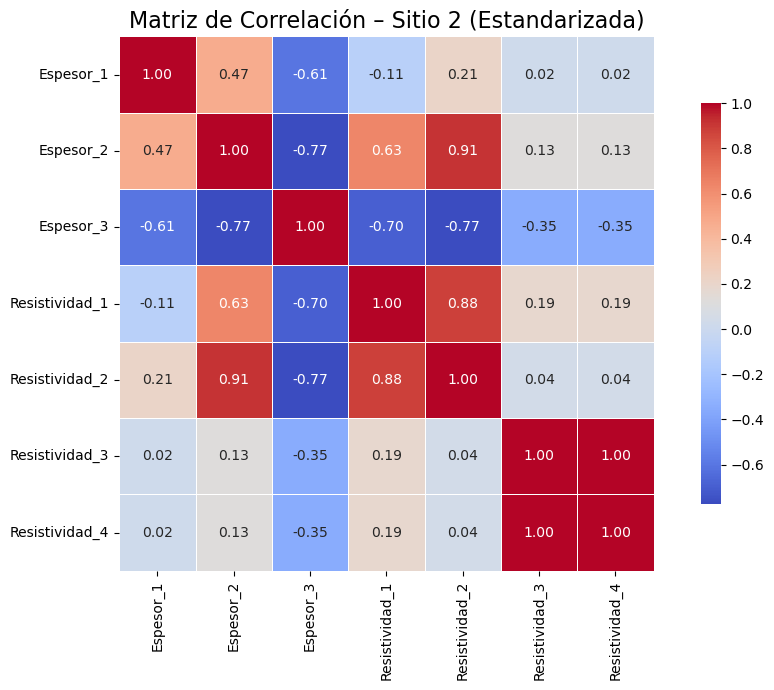

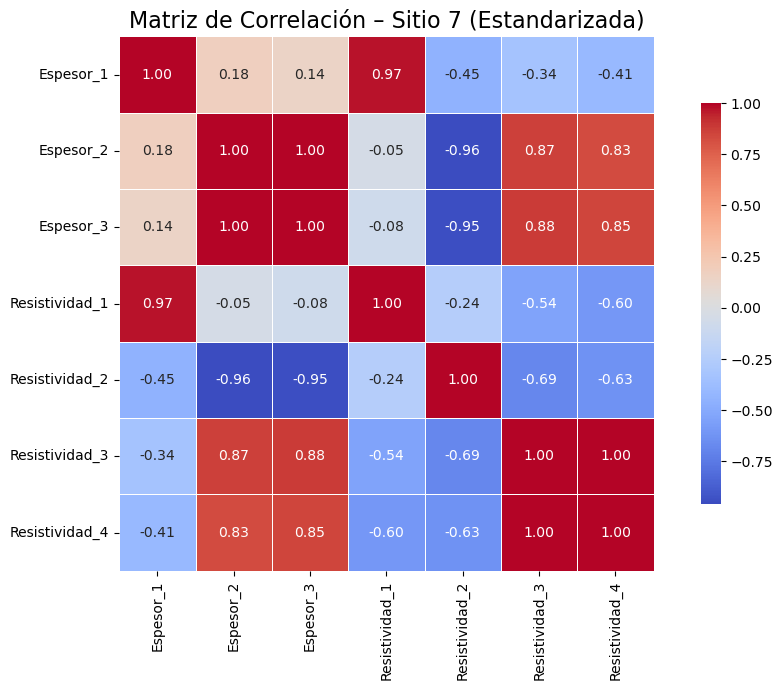

In [12]:
df = pd.read_csv('DATOS/Modelos-caracterizados-completo.csv')

# === 1. Filtrar por sitio 2 ===
sitio_df = df[df['Sitio'] == 2]

# === 2. Definir columnas de interés ===
columnas = [
    'Espesor_1', 'Espesor_2', 'Espesor_3',
    'Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4'
]

# === 3. Iterar sobre los sitios deseados ===
for sitio in [2, 7]:
    # Filtrar datos del sitio
    sitio_df = df[df['Sitio'] == sitio]
    
    # Eliminar filas con datos faltantes
    sitio_data = sitio_df[columnas].dropna()
    
    # Verificar si hay suficientes datos para procesar
    if sitio_data.empty:
        print(f"[!] Sitio {sitio} no tiene datos completos para las columnas seleccionadas.")
        continue

    # Estandarizar los datos
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(sitio_data)

    # Calcular matriz de correlación de Pearson
    correlation_matrix = np.corrcoef(scaled_data, rowvar=False)

    # Convertir a DataFrame con etiquetas
    correlation_df = pd.DataFrame(
        correlation_matrix,
        index=columnas,
        columns=columnas
    )

    # Visualizar la matriz de correlación
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        correlation_df,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(f"Matriz de Correlación – Sitio {sitio} (Estandarizada)", fontsize=16)
    plt.tight_layout()
    plt.show()


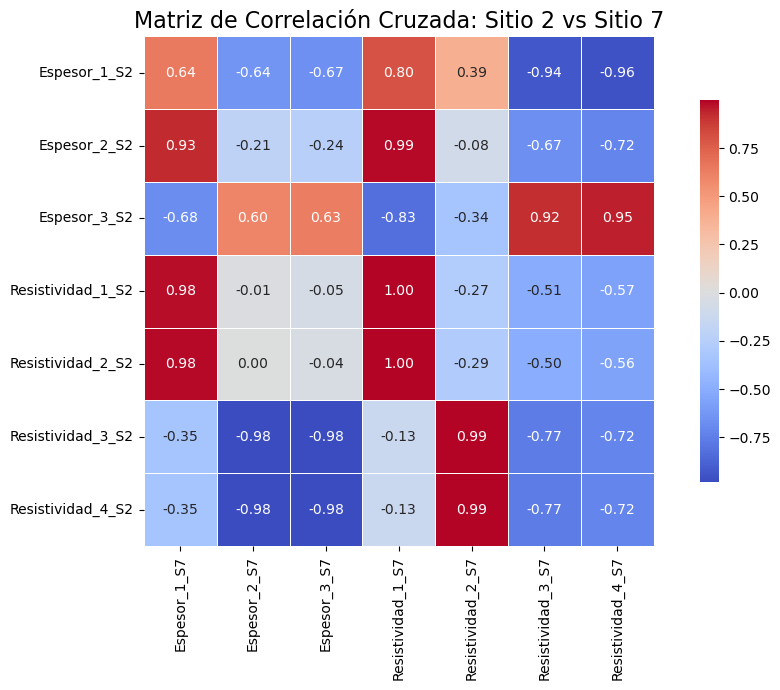

                   Espesor_1_S7  Espesor_2_S7  Espesor_3_S7  \
Espesor_1_S2              0.644        -0.638        -0.666   
Espesor_2_S2              0.926        -0.205        -0.242   
Espesor_3_S2             -0.682         0.599         0.628   
Resistividad_1_S2         0.982        -0.013        -0.051   
Resistividad_2_S2         0.984         0.000        -0.037   
Resistividad_3_S2        -0.346        -0.985        -0.978   
Resistividad_4_S2        -0.346        -0.985        -0.978   

                   Resistividad_1_S7  Resistividad_2_S7  Resistividad_3_S7  \
Espesor_1_S2                   0.799              0.390             -0.938   
Espesor_2_S2                   0.987             -0.084             -0.667   
Espesor_3_S2                  -0.828             -0.344              0.919   
Resistividad_1_S2              0.999             -0.274             -0.512   
Resistividad_2_S2              0.999             -0.287             -0.500   
Resistividad_3_S2          

In [13]:
variables = [
    'Espesor_1', 'Espesor_2', 'Espesor_3',
    'Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4'
]

# === 3. Filtrar sitios y limpiar nulos ===
df2 = df[df['Sitio'] == 2][variables].dropna().reset_index(drop=True)
df7 = df[df['Sitio'] == 7][variables].dropna().reset_index(drop=True)

# === 4. Igualar tamaño de los DataFrames para alineación
min_len = min(len(df2), len(df7))
df2 = df2.iloc[:min_len]
df7 = df7.iloc[:min_len]

# === 5. Renombrar columnas para distinguir sitio
df2.columns = [f"{col}_S2" for col in df2.columns]
df7.columns = [f"{col}_S7" for col in df7.columns]

# === 6. Concatenar ambos dataframes horizontalmente
df_combined = pd.concat([df2, df7], axis=1)

# === 7. Calcular matriz de correlación completa
correlation_matrix = df_combined.corr()

# === 8. Extraer la submatriz cruzada: sitio 2 vs sitio 7
submatrix = correlation_matrix.loc[
    [col for col in correlation_matrix.index if col.endswith('_S2')],
    [col for col in correlation_matrix.columns if col.endswith('_S7')]
]

# === 9. Visualizar la matriz cruzada
plt.figure(figsize=(10, 7))
sns.heatmap(
    submatrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)
plt.title("Matriz de Correlación Cruzada: Sitio 2 vs Sitio 7", fontsize=16)
plt.tight_layout()
plt.show()
# Imprimir la submatriz
print(submatrix.round(3))



No se observa una correlacion directa entre los sitios 2 y 7 por lo tanto la comparacion entre resultados no tendra sesgo.

In [14]:
#######################################################################################################
## iniciamos calculando los datos estadisticos y los hiperparametros de cada espesor para cada sitio ##
#######################################################################################################

from scipy import stats
from scipy.stats import norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma


columnas_espesores = ["Espesor_1", "Espesor_2", "Espesor_3"]
distribuciones = [norm, lognorm, gamma, expon, weibull_min, beta, genextreme, loggamma]
sitios_deseados = [2, 7]

resultados_por_espesor = []

# Función para calcular el AIC
def calcular_aic(log_likelihood, k):
    return 2 * k - 2 * log_likelihood


df_filtrado = df[df["Sitio"].isin(sitios_deseados)]


for sitio, datos_sitio in df_filtrado.groupby("Sitio"):
    for espesor in columnas_espesores:
        espesores = datos_sitio[espesor].dropna()

        if len(espesores) < 2:
            continue  

        resultados = {}
        for dist in distribuciones:
            try:
                params = dist.fit(espesores)
                log_likelihood = np.sum(dist.logpdf(espesores, *params))
                aic = calcular_aic(log_likelihood, len(params))
                ks_stat, p_value = stats.kstest(espesores, dist.cdf, args=params)

                resultados[dist.name] = {
                    'params': params,
                    'KS_stat': ks_stat,
                    'p_value': p_value,
                    'log_likelihood': log_likelihood,
                    'AIC': aic
                }
            except Exception:       #######################################
                continue            ## Ignorar distribuciones que fallen ##
                                    #######################################
        if not resultados:
            continue

     
        mejor_dist = sorted(resultados.items(), key=lambda x: x[1]['AIC'])[0]

        estadisticas = espesores.describe()
        mediana = np.median(espesores)
        moda = stats.mode(espesores, keepdims=False).mode

        resultados_por_espesor.append({
            "Sitio": sitio,
            "Espesor": espesor,
            "Media": estadisticas["mean"],
            "Desviación estándar": estadisticas["std"],
            "Mínimo": estadisticas["min"],
            "Máximo": estadisticas["max"],
            "Mediana": mediana,
            "Moda": moda,
            "Mejor_Distribucion": mejor_dist[0],
            "Parametros": mejor_dist[1]['params'],
            "KS_stat": mejor_dist[1]['KS_stat'],
            "p_value": mejor_dist[1]['p_value'],
            "AIC": mejor_dist[1]['AIC']
        })




resultados_df = pd.DataFrame(resultados_por_espesor)
print(resultados_df.round(5))

# a CSV
df_esta_Hip_27 = pd.DataFrame(resultados_por_espesor)
estadistico_hiperparametros_27 =  "estadistico_hiperparametros_27_2.csv"
df_esta_Hip_27.to_csv(estadistico_hiperparametros_27, index=False)


# se guarda en .pkl
joblib.dump(resultados_por_espesor, "resultados_por_espesor.pkl")



c:\Users\juanj\.conda\envs\pg\Lib\site-packages\scipy\stats\_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


   Sitio    Espesor      Media  Desviación estándar  Mínimo  Máximo  Mediana  \
0      2  Espesor_1    2.64000              0.84439     1.3     3.5      3.0   
1      2  Espesor_2   10.80000              7.07637     4.5    23.0      9.0   
2      2  Espesor_3   49.50000             14.56880    32.0    66.0     45.5   
3      7  Espesor_1   17.66667             19.65536     3.0    40.0     10.0   
4      7  Espesor_2   20.00000              6.00000    14.0    26.0     20.0   
5      7  Espesor_3  140.66667             62.04300    80.0   204.0    138.0   

   Moda Mejor_Distribucion                                         Parametros  \
0   3.0            lognorm  (14.61366159926754, 1.2999999999999998, 0.0010...   
1   9.0            lognorm  (14.605073800542122, 4.499999999999999, 0.0042...   
2  32.0               beta  (0.40022083185560214, 0.43981305675127835, 31....   
3   3.0            lognorm  (17.986993737838386, 2.9999999999999996, 4.863...   
4  14.0            lognorm  (17.02

['resultados_por_espesor.pkl']

### Importante!!!!

En esta etapa ya que el numeor de datos obtenidos de sondeos directos son limitados, es decir, por estudio se realizan de 3 a 5 sondeos SPT o PCA, no es posible establecer una distribucion estadistica para cada espesor, para ello requeririamos almenos 30 sondeos en los cuales se tengan representados todos los espesores de todas las unidades deseadas, por lo cual se procede a generar variaciones de espesor considerando unicamente los intervalos maximos y minimos, en una version anterior se generan intervalos deacuardo a la distribucion de mejor ajuste.

In [15]:
resultados_cargados = joblib.load("resultados_por_espesor.pkl")
# Lista de sitios y espesores
sitios = [2, 7]
espesores = ["Espesor_1", "Espesor_2", "Espesor_3"]

# Recorrer y generar variables dinámicamente
for sitio in sitios:
    for espesor in espesores:
        resultado = next(
            (r for r in resultados_cargados if r["Sitio"] == sitio and r["Espesor"] == espesor),
            None
        )
        if resultado:
            idx = espesor.split("_")[1]  # Extrae el número del espesor
            base = f"S{sitio}E{idx}"     # Ejemplo: "S2E1"

            # Crear variables dinámicas con globals()
            globals()[f"{base}Min"] = resultado["Mínimo"]
            globals()[f"{base}Max"] = resultado["Máximo"]
            globals()[f"{base}Med"] = resultado["Mediana"]
            globals()[f"{base}DE"]  = resultado["Desviación estándar"]
            globals()[f"{base}MD"]  = resultado["Mejor_Distribucion"]
            globals()[f"{base}IP"]  = resultado["Parametros"]


In [16]:
# Recrear el DataFrame de estadísticas desde la información proporcionada
data = {
    'Sitio':                 [          2,           2,           2,           7,           7,           7],
    'Espesor':               ['Espesor_1', 'Espesor_2', 'Espesor_3', 'Espesor_1', 'Espesor_2', 'Espesor_3'],
    'Media':                 [    S2E1Med,     S2E2Med,     S2E3Med,     S7E1Med,     S7E2Med,     S7E3Med],
    'Desviación estándar':   [     S2E1DE,      S2E2DE,      S2E3DE,      S7E1DE,      S7E2DE,      S7E3DE],
    'Mínimo':                [    S2E1Min,     S2E2Min,     S2E3Min,     S7E1Min,     S7E2Min,     S7E3Min],
    'Máximo':                [    S2E1Max,     S2E2Max,     S2E3Max,     S7E1Max,     S7E2Max,     S7E3Max],
    'Mediana':               [    S2E1Med,     S2E2Med,     S2E3Med,     S7E1Med,     S7E2Med,     S7E3Med]
}

stats_df = pd.DataFrame(data)
stats_df['Media'] = stats_df['Media'].fillna(0)  # Por si hay NaN, pero no hay

# Número de variaciones por sitio
n_variations = 30000

# Lista para almacenar las filas del DataFrame final
rows = []

# ID autoincremental global
global_id = 1

# Generar datos para cada sitio
for sitio in stats_df['Sitio'].unique():
    # Filtrar estadísticas para este sitio
    site_stats = stats_df[stats_df['Sitio'] == sitio]
    
    # Preparar arrays para cada espesor
    espesores = {}
    for _, row in site_stats.iterrows():
        espesor_name = row['Espesor']
        min_val = row['Mínimo']
        max_val = row['Máximo']
        
        # Generar valores uniformes entre min y max
        values = np.random.uniform(min_val, max_val, n_variations)
        
        # Shuffle para aleatoriedad
        np.random.shuffle(values)
        
        espesores[espesor_name] = values
    
    # Para cada variación, crear una fila
    for var_idx in range(n_variations):
        row = {
            'id': global_id,
            'sitio+variante': f'sitio{sitio}_variante{var_idx + 1}'
        }
        for espesor_name in ['Espesor_1', 'Espesor_2', 'Espesor_3']:
            row[espesor_name] = espesores[espesor_name][var_idx]
        
        rows.append(row)
        global_id += 1

final_df = pd.DataFrame(rows)

###################################################################################
#### se declaran los vbalores de resitividad identificados en los sitios 2 y 7 ####
####   estos valores se integraran de manera aleatoria empleando un shuffle()  ####
###################################################################################

listas_sitio2 = {
    'res1': [56, 56.6, 95, 4, 48],
    'res2': [350, 350, 1500, 45, 460],
    'res3': [11000, 1500, 4800, 3400, 2300],
    'res4': [13200, 1800, 5760, 4080, 2760],
    'AB2_1':[1],
    'AB2_2':[2],
    'AB2_3':[4],
    'AB2_4':[5],
    'AB2_5':[7],
    'AB2_6':[8],
    'AB2_7':[10],
    'AB2_8':[12],
    'AB2_9':[15],
    'AB2_10':[18],
    'AB2_11':[20],
    'AB2_12':[23],
    'AB2_13':[28],
    'AB2_14':[30],
    'AB2_15':[33],
    'AB2_16':[38],
    'AB2_17':[40],
    'AB2_18':[43], 
    'AB2_19':[48],
    'AB2_20':[50],
    'AB2_21':[54],
    'AB2_22':[58],
    'AB2_23':[60],
    'AB2_24':[64],
    'AB2_25':[68],
    'AB2_26':[70],
    'AB2_27':[75],
    'AB2_28':[80],
    'AB2_29':[85],
    'AB2_30':[90]
}

listas_sitio7 = {
    'res1': [156, 17, 750],
    'res2': [264, 48, 100],
    'res3': [85, 360, 85],
    'res4': [129, 432, 102],
    'AB2_1':[1, 1, 1],
    'AB2_2':[2, 10, 10],
    'AB2_3':[5, 15, 20],
    'AB2_4':[10, 20, 30],
    'AB2_5':[15, 25, 40],
    'AB2_6':[20, 30, 50],
    'AB2_7':[25, 35, 60],
    'AB2_8':[30, 40, 70],
    'AB2_9':[35, 45, 80],
    'AB2_10':[40, 50, 90],
    'AB2_11':[50, 55, 100],
    'AB2_12':[60, 60, 110],
    'AB2_13':[70, 65, 120],
    'AB2_14':[80, 70, 130],
    'AB2_15':[90, 75, 140],
    'AB2_16':[100, 80, 150],
    'AB2_17':[110, 85, 160],
    'AB2_18':[120, 90, 170],
    'AB2_19':[130, 100, 180],
    'AB2_20':[140, 130, 190],
    'AB2_21':[150, 150, 200],
    'AB2_22':[160, 180, 210],
    'AB2_23':[170, 230, 220],
    'AB2_24':[180, 260, 230],
    'AB2_25':[190, 280, 240],
    'AB2_26':[200, 300, 250],
    'AB2_27':[210, 310, 260],
    'AB2_28':[220, 330, 270],
    'AB2_29':[230, 360, 280],
    'AB2_30':[240, 400, 330]
}


np.random.seed(42)  # semilla de aleatoriedad para reproducibilidad de los valores de resistividad

for sitio in [2, 7]:
    mask = final_df['sitio+variante'].str.startswith(f'sitio{sitio}')
    listas = listas_sitio2 if sitio == 2 else listas_sitio7
    
    for col_name in ['res1', 'res2', 'res3',
                     'res4', 'AB2_1', 'AB2_2',
                     'AB2_3', 'AB2_4', 'AB2_5',
                     'AB2_6', 'AB2_7', 'AB2_8',
                     'AB2_9', 'AB2_10', 'AB2_11',
                     'AB2_12', 'AB2_13', 'AB2_14',
                     'AB2_15', 'AB2_16', 'AB2_17',
                     'AB2_18', 'AB2_19', 'AB2_20',
                     'AB2_21', 'AB2_22', 'AB2_23',
                     'AB2_24', 'AB2_25', 'AB2_26',
                     'AB2_27', 'AB2_28', 'AB2_29', 'AB2_30']:
        lista = listas[col_name]
        values = np.random.choice(lista, size=sum(mask))
        np.random.shuffle(values)
        final_df.loc[mask, col_name] = values


# Guardar en CSV
final_df.to_csv('VARIANTE-ESPESORES-COMPLETO.csv', index=False)

# Imprimir las primeras filas y forma
print(stats_df.head())

print(final_df.head())
print(f"\nForma del DataFrame: {final_df.shape}")

print(final_df.describe)
#print("\nEstadísticas de verificación para Sitio 2, Espesor_1:")
#print(final_df[final_df['sitio+variante'].str.startswith('sitio2')]['Espesor_1'].describe())

   Sitio    Espesor  Media  Desviación estándar  Mínimo  Máximo  Mediana
0      2  Espesor_1    3.0             0.844393     1.3     3.5      3.0
1      2  Espesor_2    9.0             7.076369     4.5    23.0      9.0
2      2  Espesor_3   45.5            14.568802    32.0    66.0     45.5
3      7  Espesor_1   10.0            19.655364     3.0    40.0     10.0
4      7  Espesor_2   20.0             6.000000    14.0    26.0     20.0
   id    sitio+variante  Espesor_1  Espesor_2  Espesor_3  res1   res2  \
0   1  sitio2_variante1   1.637957   5.583682  57.368933  56.6  350.0   
1   2  sitio2_variante2   2.190942   6.784189  50.463987  56.6  460.0   
2   3  sitio2_variante3   1.442500   5.902160  50.829418  56.6   45.0   
3   4  sitio2_variante4   3.130548  11.625199  53.561846  56.0   45.0   
4   5  sitio2_variante5   1.584708   7.890154  33.626335  95.0  350.0   

      res3     res4  AB2_1  ...  AB2_21  AB2_22  AB2_23  AB2_24  AB2_25  \
0   3400.0   1800.0    1.0  ...    54.0    58.0 

In [17]:
print(final_df.describe)

<bound method NDFrame.describe of           id        sitio+variante  Espesor_1  Espesor_2   Espesor_3   res1  \
0          1      sitio2_variante1   1.637957   5.583682   57.368933   56.6   
1          2      sitio2_variante2   2.190942   6.784189   50.463987   56.6   
2          3      sitio2_variante3   1.442500   5.902160   50.829418   56.6   
3          4      sitio2_variante4   3.130548  11.625199   53.561846   56.0   
4          5      sitio2_variante5   1.584708   7.890154   33.626335   95.0   
...      ...                   ...        ...        ...         ...    ...   
59995  59996  sitio7_variante29996  32.328409  20.300152  140.155758  156.0   
59996  59997  sitio7_variante29997  18.842412  15.755590  165.874835  750.0   
59997  59998  sitio7_variante29998  24.726200  14.840110  170.361038   17.0   
59998  59999  sitio7_variante29999  24.124079  14.623777  147.056589  156.0   
59999  60000  sitio7_variante30000  35.318949  17.982787  138.308386  750.0   

        res2     

In [18]:
#from pygimli.physics import VESManager
#import pandas as pd

df2 = final_df.dropna()

# Lista de resultados por modelo (una fila cada uno)
resultados2 = []

for _, row in df2.iterrows():
    modelo_id = row["sitio+variante"]  # Nombre del modelo
    sitio_id = row["id"]  # Sitio correspondiente
    
    # Extraemos espesores y resistividades
    espesores = (
        row.filter(like="Espesor_")
        .dropna()
        .astype(str)
        .replace("∞", "")
        .astype(float)
        .tolist()
    )
    resistividades = (
        row.filter(like="Resistividad_")
        .dropna()
        .astype(float)
        .tolist()
    )
    
    synthModel = espesores + resistividades  # modelo sintético

    # Extraemos los valores de apertura AB2
    ab2 = row.filter(like="AB2_").dropna().astype(float).values

    # Simulación empleando PyGIMLi
    ves = VESManager()
    rhoa, err = ves.simulate(
        synthModel, ab2=ab2, mn2=ab2 / 3, noiseLevel=0.09, seed=1337
    )

    # --------------------------
    # Guardar todo en UNA FILA
    # --------------------------
    fila = {
        "Modelo_ID": modelo_id,
        "Sitio_ID": sitio_id,
    }

    # Agregar columnas AB2_x y Rhoa_x
    for i in range(len(ab2)):
        fila[f"AB2_{i+1}"] = ab2[i]
        fila[f"Rhoa_{i+1}"] = rhoa[i]

    resultados2.append(fila)

# Convertir resultados en DataFrame
df_resultados2 = pd.DataFrame(resultados2)

# Guardar en CSV
csv_output_path = "RESULTADOS-Simulacion-Tesis-FormatoFila.csv"
df_resultados2.to_csv(csv_output_path, index=False)

# Vista previa
print(df_resultados2.head())


          Modelo_ID  Sitio_ID  AB2_1     Rhoa_1  AB2_2     Rhoa_2  AB2_3  \
0  sitio2_variante1         1    1.0   5.448771    2.0   6.641951    4.0   
1  sitio2_variante2         2    1.0   6.462048    2.0   7.202436    4.0   
2  sitio2_variante3         3    1.0   5.840483    2.0   7.383659    4.0   
3  sitio2_variante4         4    1.0  10.943280    2.0  11.506477    4.0   
4  sitio2_variante5         5    1.0   7.633913    2.0   8.951373    4.0   

      Rhoa_3  AB2_4     Rhoa_4  ...  AB2_26    Rhoa_26  AB2_27    Rhoa_27  \
0  10.476524    5.0  10.786304  ...    70.0  50.582884    75.0  51.362618   
1   9.954389    5.0  10.010873  ...    70.0  44.810052    75.0  45.476170   
2  11.848728    5.0  12.119161  ...    70.0  47.110471    75.0  47.646338   
3  13.552670    5.0  12.919360  ...    70.0  48.711967    75.0  49.342298   
4  12.771748    5.0  12.605810  ...    70.0  32.982069    75.0  33.178036   

   AB2_28    Rhoa_28  AB2_29    Rhoa_29  AB2_30    Rhoa_30  
0    80.0  38.55326

In [19]:
print(df_resultados2.describe)

<bound method NDFrame.describe of                   Modelo_ID  Sitio_ID  AB2_1     Rhoa_1  AB2_2     Rhoa_2  \
0          sitio2_variante1         1    1.0   5.448771    2.0   6.641951   
1          sitio2_variante2         2    1.0   6.462048    2.0   7.202436   
2          sitio2_variante3         3    1.0   5.840483    2.0   7.383659   
3          sitio2_variante4         4    1.0  10.943280    2.0  11.506477   
4          sitio2_variante5         5    1.0   7.633913    2.0   8.951373   
...                     ...       ...    ...        ...    ...        ...   
59995  sitio7_variante29996     59996    1.0  19.015524   10.0  19.507902   
59996  sitio7_variante29997     59997    1.0  14.758932    2.0  15.064141   
59997  sitio7_variante29998     59998    1.0  13.901123    2.0  14.186889   
59998  sitio7_variante29999     59999    1.0  13.698487   10.0  14.173151   
59999  sitio7_variante30000     60000    1.0  16.844787   10.0  17.262541   

       AB2_3     Rhoa_3  AB2_4     Rhoa_4

In [20]:
# Asegurar que la clave tenga el mismo nombre
df_resultados2 = df_resultados2.rename(columns={"Modelo_ID": "sitio+variante"})

# Fusionar ambos DataFrames en base al identificador
final_merge = final_df.merge(df_resultados2, on="sitio+variante", how="left")

# Guardar el resultado
final_merge.to_csv("FINAL_MERGE_RESULTADOS.csv", index=False)

final_merge = final_merge.loc[:, ~final_merge.columns.str.endswith("y")]


print(final_merge.head())


   id    sitio+variante  Espesor_1  Espesor_2  Espesor_3  res1   res2  \
0   1  sitio2_variante1   1.637957   5.583682  57.368933  56.6  350.0   
1   2  sitio2_variante2   2.190942   6.784189  50.463987  56.6  460.0   
2   3  sitio2_variante3   1.442500   5.902160  50.829418  56.6   45.0   
3   4  sitio2_variante4   3.130548  11.625199  53.561846  56.0   45.0   
4   5  sitio2_variante5   1.584708   7.890154  33.626335  95.0  350.0   

      res3     res4  AB2_1_x  ...    Rhoa_21    Rhoa_22    Rhoa_23    Rhoa_24  \
0   3400.0   1800.0      1.0  ...  41.576572  48.053555  42.708277  47.456129   
1  11000.0   2760.0      1.0  ...  36.914630  42.637532  37.883297  42.071274   
2   3400.0  13200.0      1.0  ...  39.374678  45.288249  40.160594  44.440895   
3  11000.0   4080.0      1.0  ...  40.450033  46.612838  41.371144  45.854114   
4   2300.0   2760.0      1.0  ...  28.235019  32.242727  28.499214  31.350676   

     Rhoa_25    Rhoa_26    Rhoa_27    Rhoa_28    Rhoa_29    Rhoa_30  
0  5

In [21]:
print(final_merge.columns.tolist())


['id', 'sitio+variante', 'Espesor_1', 'Espesor_2', 'Espesor_3', 'res1', 'res2', 'res3', 'res4', 'AB2_1_x', 'AB2_2_x', 'AB2_3_x', 'AB2_4_x', 'AB2_5_x', 'AB2_6_x', 'AB2_7_x', 'AB2_8_x', 'AB2_9_x', 'AB2_10_x', 'AB2_11_x', 'AB2_12_x', 'AB2_13_x', 'AB2_14_x', 'AB2_15_x', 'AB2_16_x', 'AB2_17_x', 'AB2_18_x', 'AB2_19_x', 'AB2_20_x', 'AB2_21_x', 'AB2_22_x', 'AB2_23_x', 'AB2_24_x', 'AB2_25_x', 'AB2_26_x', 'AB2_27_x', 'AB2_28_x', 'AB2_29_x', 'AB2_30_x', 'Sitio_ID', 'Rhoa_1', 'Rhoa_2', 'Rhoa_3', 'Rhoa_4', 'Rhoa_5', 'Rhoa_6', 'Rhoa_7', 'Rhoa_8', 'Rhoa_9', 'Rhoa_10', 'Rhoa_11', 'Rhoa_12', 'Rhoa_13', 'Rhoa_14', 'Rhoa_15', 'Rhoa_16', 'Rhoa_17', 'Rhoa_18', 'Rhoa_19', 'Rhoa_20', 'Rhoa_21', 'Rhoa_22', 'Rhoa_23', 'Rhoa_24', 'Rhoa_25', 'Rhoa_26', 'Rhoa_27', 'Rhoa_28', 'Rhoa_29', 'Rhoa_30']


In [22]:
df_completo_MR = final_merge.rename(columns={"AB2_1_x": "AB2_1", "AB2_2_x": "AB2_2", "AB2_3_x": "AB2_3", "AB2_4_x": "AB2_4", "AB2_1_x": "AB2_1", "AB2_5_x": "AB2_5", "AB2_6_x": "AB2_6", "AB2_7_x": "AB2_7", "AB2_8_x": "AB2_8", "AB2_9_x": "AB2_9", "AB2_10_x": "AB2_10", "AB2_11_x": "AB2_11", "AB2_12_x": "AB2_12", "AB2_13_x": "AB2_13", "AB2_14_x": "AB2_14", "AB2_15_x": "AB2_15", "AB2_16_x": "AB2_16", "AB2_17_x": "AB2_17", "AB2_18_x": "AB2_18", "AB2_19_x": "AB2_19", "AB2_20_x": "AB2_20", "AB2_21_x": "AB2_21", "AB2_22_x": "AB2_22", "AB2_23_x": "AB2_23", "AB2_24_x": "AB2_24", "AB2_25_x": "AB2_25", "AB2_26_x": "AB2_26", "AB2_27_x": "AB2_27", "AB2_28_x": "AB2_28", "AB2_29_x": "AB2_29", "AB2_30_x": "AB2_30"})

In [23]:
print(df_completo_MR.columns.tolist())

['id', 'sitio+variante', 'Espesor_1', 'Espesor_2', 'Espesor_3', 'res1', 'res2', 'res3', 'res4', 'AB2_1', 'AB2_2', 'AB2_3', 'AB2_4', 'AB2_5', 'AB2_6', 'AB2_7', 'AB2_8', 'AB2_9', 'AB2_10', 'AB2_11', 'AB2_12', 'AB2_13', 'AB2_14', 'AB2_15', 'AB2_16', 'AB2_17', 'AB2_18', 'AB2_19', 'AB2_20', 'AB2_21', 'AB2_22', 'AB2_23', 'AB2_24', 'AB2_25', 'AB2_26', 'AB2_27', 'AB2_28', 'AB2_29', 'AB2_30', 'Sitio_ID', 'Rhoa_1', 'Rhoa_2', 'Rhoa_3', 'Rhoa_4', 'Rhoa_5', 'Rhoa_6', 'Rhoa_7', 'Rhoa_8', 'Rhoa_9', 'Rhoa_10', 'Rhoa_11', 'Rhoa_12', 'Rhoa_13', 'Rhoa_14', 'Rhoa_15', 'Rhoa_16', 'Rhoa_17', 'Rhoa_18', 'Rhoa_19', 'Rhoa_20', 'Rhoa_21', 'Rhoa_22', 'Rhoa_23', 'Rhoa_24', 'Rhoa_25', 'Rhoa_26', 'Rhoa_27', 'Rhoa_28', 'Rhoa_29', 'Rhoa_30']


In [24]:
df_completo_MR = df_completo_MR.drop(columns=["Sitio_ID"])
df_completo_MR =df_completo_MR.rename(columns={"sitio+variante": "id_siva"})

In [25]:
print(df_completo_MR.columns.tolist())

['id', 'id_siva', 'Espesor_1', 'Espesor_2', 'Espesor_3', 'res1', 'res2', 'res3', 'res4', 'AB2_1', 'AB2_2', 'AB2_3', 'AB2_4', 'AB2_5', 'AB2_6', 'AB2_7', 'AB2_8', 'AB2_9', 'AB2_10', 'AB2_11', 'AB2_12', 'AB2_13', 'AB2_14', 'AB2_15', 'AB2_16', 'AB2_17', 'AB2_18', 'AB2_19', 'AB2_20', 'AB2_21', 'AB2_22', 'AB2_23', 'AB2_24', 'AB2_25', 'AB2_26', 'AB2_27', 'AB2_28', 'AB2_29', 'AB2_30', 'Rhoa_1', 'Rhoa_2', 'Rhoa_3', 'Rhoa_4', 'Rhoa_5', 'Rhoa_6', 'Rhoa_7', 'Rhoa_8', 'Rhoa_9', 'Rhoa_10', 'Rhoa_11', 'Rhoa_12', 'Rhoa_13', 'Rhoa_14', 'Rhoa_15', 'Rhoa_16', 'Rhoa_17', 'Rhoa_18', 'Rhoa_19', 'Rhoa_20', 'Rhoa_21', 'Rhoa_22', 'Rhoa_23', 'Rhoa_24', 'Rhoa_25', 'Rhoa_26', 'Rhoa_27', 'Rhoa_28', 'Rhoa_29', 'Rhoa_30']


In [26]:
df_completo_MR["z_un3"] = df_completo_MR["Espesor_1"] + df_completo_MR["Espesor_2"] + df_completo_MR["Espesor_3"]
df_completo_MR["z_un2"] = df_completo_MR["z_un3"] - df_completo_MR["Espesor_3"]
df_completo_MR["z_un1"] = df_completo_MR["z_un3"] - df_completo_MR["Espesor_2"] - df_completo_MR["Espesor_3"]
df_completo_MR["z_un4"] = (df_completo_MR["AB2_30"] * 2 )* 0.3
#
df_completo_MR = df_completo_MR[df_completo_MR["z_un3"] <= df_completo_MR["z_un4"]].reset_index(drop=True)

In [27]:
print(df_completo_MR.head())
print(df_completo_MR.columns.tolist())


   id            id_siva  Espesor_1  Espesor_2  Espesor_3  res1   res2  \
0   5   sitio2_variante5   1.584708   7.890154  33.626335  95.0  350.0   
1   8   sitio2_variante8   1.590742  10.355699  37.446268  95.0  460.0   
2  19  sitio2_variante19   1.380383   7.299816  44.840813  56.6  350.0   
3  29  sitio2_variante29   2.139174   5.465517  46.081917  95.0  350.0   
4  36  sitio2_variante36   1.462230   6.466164  32.777753   4.0  350.0   

      res3    res4  AB2_1  ...    Rhoa_25    Rhoa_26    Rhoa_27    Rhoa_28  \
0   2300.0  2760.0    1.0  ...  36.285253  32.982069  33.178036  24.699770   
1   2300.0  4080.0    1.0  ...  40.749957  37.025760  37.213182  27.683188   
2   1500.0  2760.0    1.0  ...  47.588517  43.287952  43.616416  32.516340   
3  11000.0  5760.0    1.0  ...  43.906689  40.091249  40.748895  30.613288   
4   3400.0  5760.0    1.0  ...  35.150373  31.959439  32.169415  23.961680   

     Rhoa_29    Rhoa_30      z_un3      z_un2     z_un1  z_un4  
0  31.862423  33.0125

In [28]:
print(df_completo_MR.describe)

<bound method NDFrame.describe of           id               id_siva  Espesor_1  Espesor_2   Espesor_3   res1  \
0          5      sitio2_variante5   1.584708   7.890154   33.626335   95.0   
1          8      sitio2_variante8   1.590742  10.355699   37.446268   95.0   
2         19     sitio2_variante19   1.380383   7.299816   44.840813   56.6   
3         29     sitio2_variante29   2.139174   5.465517   46.081917   95.0   
4         36     sitio2_variante36   1.462230   6.466164   32.777753    4.0   
...      ...                   ...        ...        ...         ...    ...   
22826  59991  sitio7_variante29991   8.504939  22.401363  202.780843   17.0   
22827  59993  sitio7_variante29993  33.550412  14.719309  133.902488  156.0   
22828  59996  sitio7_variante29996  32.328409  20.300152  140.155758  156.0   
22829  59999  sitio7_variante29999  24.124079  14.623777  147.056589  156.0   
22830  60000  sitio7_variante30000  35.318949  17.982787  138.308386  750.0   

        res2     

In [29]:
# Copia del DataFrame
df = df_completo_MR.copy()


# Paso 1: generar 30 profundidades
step = df["z_un4"] / 30.0
for i in range(1, 31):
    df[f"Z_{i}"] = step * i


# Paso 2: asignar resistividades según rangos
for i in range(1, 31):
    z_col = f"Z_{i}"
    r_col = f"R_{i}"
    conds = [
        (df[z_col] <= df["z_un1"]),
        (df[z_col] > df["z_un1"]) & (df[z_col] <= df["z_un2"]),
        (df[z_col] > df["z_un2"]) & (df[z_col] <= df["z_un3"]),
        (df[z_col] > df["z_un3"]) & (df[z_col] <= df["z_un4"]),
        ]
    vals = [df["res1"], df["res2"], df["res3"], df["res4"]]
    df[r_col] = np.select(conds, vals, default=np.nan)


# Mostrar ejemplo del nuevo DataFrame con columnas agregadas
print(df.head())
print(df.columns.tolist())

   id            id_siva  Espesor_1  Espesor_2  Espesor_3  res1   res2  \
0   5   sitio2_variante5   1.584708   7.890154  33.626335  95.0  350.0   
1   8   sitio2_variante8   1.590742  10.355699  37.446268  95.0  460.0   
2  19  sitio2_variante19   1.380383   7.299816  44.840813  56.6  350.0   
3  29  sitio2_variante29   2.139174   5.465517  46.081917  95.0  350.0   
4  36  sitio2_variante36   1.462230   6.466164  32.777753   4.0  350.0   

      res3    res4  AB2_1  ...     R_21     R_22     R_23     R_24     R_25  \
0   2300.0  2760.0    1.0  ...   2300.0   2300.0   2300.0   2760.0   2760.0   
1   2300.0  4080.0    1.0  ...   2300.0   2300.0   2300.0   2300.0   2300.0   
2   1500.0  2760.0    1.0  ...   1500.0   1500.0   1500.0   1500.0   1500.0   
3  11000.0  5760.0    1.0  ...  11000.0  11000.0  11000.0  11000.0  11000.0   
4   3400.0  5760.0    1.0  ...   3400.0   3400.0   5760.0   5760.0   5760.0   

      R_26     R_27     R_28     R_29    R_30  
0   2760.0   2760.0   2760.0   2

In [30]:
df = df.drop(columns=['Espesor_1', 'Espesor_2', 'Espesor_3', 'res1', 'res2', 'res3', 'res4', 'z_un3', 'z_un2', 'z_un1', 'z_un4'])
print(df.columns.tolist())

['id', 'id_siva', 'AB2_1', 'AB2_2', 'AB2_3', 'AB2_4', 'AB2_5', 'AB2_6', 'AB2_7', 'AB2_8', 'AB2_9', 'AB2_10', 'AB2_11', 'AB2_12', 'AB2_13', 'AB2_14', 'AB2_15', 'AB2_16', 'AB2_17', 'AB2_18', 'AB2_19', 'AB2_20', 'AB2_21', 'AB2_22', 'AB2_23', 'AB2_24', 'AB2_25', 'AB2_26', 'AB2_27', 'AB2_28', 'AB2_29', 'AB2_30', 'Rhoa_1', 'Rhoa_2', 'Rhoa_3', 'Rhoa_4', 'Rhoa_5', 'Rhoa_6', 'Rhoa_7', 'Rhoa_8', 'Rhoa_9', 'Rhoa_10', 'Rhoa_11', 'Rhoa_12', 'Rhoa_13', 'Rhoa_14', 'Rhoa_15', 'Rhoa_16', 'Rhoa_17', 'Rhoa_18', 'Rhoa_19', 'Rhoa_20', 'Rhoa_21', 'Rhoa_22', 'Rhoa_23', 'Rhoa_24', 'Rhoa_25', 'Rhoa_26', 'Rhoa_27', 'Rhoa_28', 'Rhoa_29', 'Rhoa_30', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'Z_15', 'Z_16', 'Z_17', 'Z_18', 'Z_19', 'Z_20', 'Z_21', 'Z_22', 'Z_23', 'Z_24', 'Z_25', 'Z_26', 'Z_27', 'Z_28', 'Z_29', 'Z_30', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_16', 'R_17', 'R_18', 'R_1

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

# Copiamos el dataframe
df_ml = df.copy()

# Seleccionar variables independientes (X)
X_cols = [f"AB2_{i}" for i in range(1, 31)] + \
         [f"Z_{i}" for i in range(1, 31)] + \
         [f"R_{i}" for i in range(1, 31)]
X = df_ml[X_cols]

# Seleccionar variable dependiente (y)
y_cols = [f"Rhoa_{i}" for i in range(1, 31)]
y = df_ml[y_cols]

# Split entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [34]:
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
# Paso 1: optimización en un solo target (ej. Rhoa_1)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_random = RandomizedSearchCV(rf, param_distributions=param_dist_rf,
                               n_iter=5, cv=3, scoring="r2", n_jobs=-1, random_state=42)
rf_random.fit(X_train, y_train.iloc[:, 0])  # solo primer output

print("Mejores hiperparámetros RF:", rf_random.best_params_)

# Paso 2: entrenar MultiOutput con esos hiperparámetros
best_rf = RandomForestRegressor(**rf_random.best_params_, random_state=42, n_jobs=-1)
rf_multi = MultiOutputRegressor(best_rf, n_jobs=-1)
rf_multi.fit(X_train, y_train)


Mejores hiperparámetros RF: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}


MultiOutputRegressor(estimator=RandomForestRegressor(min_samples_split=5,
                                                     n_jobs=-1,
                                                     random_state=42),
                     n_jobs=-1)

In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_multi = MultiOutputRegressor(GridSearchCV(rf, param_grid_rf, cv=3, scoring="r2", n_jobs=-1))
rf_multi.fit(X_train, y_train)

print("Mejores parámetros RF:", rf_multi.estimators_[0].best_params_)
print("Score RF:", rf_multi.score(X_test, y_test))


KeyboardInterrupt: 

## Support Vector Machine

In [35]:
param_grid_svr = {
    "estimator__C": [1, 10],
    "estimator__gamma": ["scale", "auto"],
    "estimator__kernel": ["rbf"]
}
svr = SVR()
svr_multi = MultiOutputRegressor(GridSearchCV(svr, param_grid_svr, cv=3, scoring="r2", n_jobs=-1))
svr_multi.fit(X_train, y_train)

print("Mejores parámetros SVM:", svr_multi.estimators_[0].best_params_)
print("Score SVM:", svr_multi.score(X_test, y_test))


ValueError: Invalid parameter 'estimator' for estimator SVR(). Valid parameters are: ['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'].

## Gradient Boosting

In [36]:
param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5]
}
gb = GradientBoostingRegressor(random_state=42)
gb_multi = MultiOutputRegressor(GridSearchCV(gb, param_grid_gb, cv=3, scoring="r2", n_jobs=-1))
gb_multi.fit(X_train, y_train)

print("Mejores parámetros GB:", gb_multi.estimators_[0].best_params_)
print("Score GB:", gb_multi.score(X_test, y_test))


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -----------------------
# Predicciones de cada modelo
# -----------------------
y_pred_rf = rf_multi.predict(X_test)
y_pred_svr = svr_multi.predict(X_test)
y_pred_gb = gb_multi.predict(X_test)

# -----------------------
# Métricas globales
# -----------------------
def print_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}")

print_metrics(y_test, y_pred_rf, "Random Forest")
print_metrics(y_test, y_pred_svr, "SVM")
print_metrics(y_test, y_pred_gb, "Gradient Boosting")

# -----------------------
# Gráficas comparativas
# -----------------------
n_samples_plot = 5  # número de curvas a graficar
indices = np.random.choice(len(y_test), n_samples_plot, replace=False)

plt.figure(figsize=(14, 8))

for i, idx in enumerate(indices, 1):
    plt.subplot(2, 3, i)
    plt.plot(y_test.iloc[idx].values, label="Real", marker="o")
    plt.plot(y_pred_rf[idx], label="RF", linestyle="--")
    plt.plot(y_pred_svr[idx], label="SVM", linestyle="--")
    plt.plot(y_pred_gb[idx], label="GB", linestyle="--")
    plt.title(f"Curva #{idx}")
    plt.xlabel("Índice de Rhoa (1-30)")
    plt.ylabel("Resistividad Aparente")
    plt.legend()

plt.tight_layout()
plt.show()
